In [1]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import SearchAssociativeRules.AprioriAssociationRules as apr
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


In [2]:
data_general = pd.read_excel('./Online Retail.xlsx')

In [3]:
data_general.groupby(by=["Country"]).count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
Country,,,,,,,
Australia,1259,1259,1259,1259,1259,1259,1259
Austria,401,401,401,401,401,401,401
Bahrain,19,19,19,19,19,19,17
Belgium,2069,2069,2069,2069,2069,2069,2069
Brazil,32,32,32,32,32,32,32
Canada,151,151,151,151,151,151,151
Channel Islands,758,758,758,758,758,758,758
Cyprus,622,622,622,622,622,622,622
Czech Republic,30,30,30,30,30,30,30


In [4]:
data_general.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Предварительная обработка полей Description и InvoiceNo

In [5]:
data_general_cleaned = data_general[data_general['InvoiceNo'].notna() & ~data_general['InvoiceNo'].astype(str).str.contains('C', na=False)]
data_general_cleaned = data_general_cleaned.dropna(subset=['Description'])
data_general_cleaned.loc[:, 'Description'] = data_general_cleaned['Description'].str.lower().str.strip()
data_general_cleaned = data_general_cleaned[data_general_cleaned['Description'].str.len() > 0]

In [6]:
data_general_cleaned.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133242
Country             0
dtype: int64

In [7]:
df_cleaned_germany = data_general_cleaned[data_general_cleaned["Country"] == "Germany"]

## Генерирование набора транзакций

In [8]:
transactions_germany = df_cleaned_germany.groupby('InvoiceNo')['Description'].apply(lambda x: ','.join(x)).reset_index()

tencoder = TransactionEncoder()
tencoder_data = tencoder.fit(transactions_germany['Description'].str.split(',')).transform(transactions_germany['Description'].str.split(','))

df_germany = pd.DataFrame(tencoder_data, columns=tencoder.columns_)

In [9]:
df_germany.columns = [col if col not in [None, '', ' '] else None for col in df_germany.columns]
df_germany = df_germany.loc[:, df_germany.columns.notnull()]  


In [10]:
df_germany

,1 hanger,billboard fonts design,birthday card,overcrowded pool.,retro spot,10 colour spaceboy pen,12 coloured party balloons,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,...,yuletide images gift wrap set,zinc heart t-light holder,zinc star t-light holder,zinc box sign home,zinc folkart sleigh bells,zinc heart lattice t-light holder,zinc metal heart decoration,zinc t-light holder star large,zinc t-light holder stars small,zinc willie winkie candle stick
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
454,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
455,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Генерирование частых наборов элементов методами apriori и fp-growth

In [13]:
frequent_itemsets_apriori = apriori(df_germany, min_support=0.1, use_colnames=True)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.6)

In [14]:
frequent_itemsets_apriori

,support,itemsets
0,0.102845,(6 ribbons rustic charm)
1,0.100656,(jumbo bag woodland animals)
2,0.115974,(plasters in tin circus parade)
3,0.107221,(plasters in tin spaceboy)
4,0.137856,(plasters in tin woodland animals)
5,0.818381,(postage)
6,0.137856,(regency cakestand 3 tier)
7,0.157549,(round snack boxes set of 4 fruits)
8,0.245077,(round snack boxes set of4 woodland)
9,0.102845,(spaceboy lunch box)


In [15]:
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(plasters in tin circus parade),(postage),0.115974,0.818381,0.100656,0.867925,1.060539,0.005746,1.375117,0.064572
1,(plasters in tin spaceboy),(postage),0.107221,0.818381,0.100656,0.938776,1.147113,0.012909,2.966448,0.143649
2,(plasters in tin woodland animals),(postage),0.137856,0.818381,0.118162,0.857143,1.047364,0.005344,1.271335,0.052453
3,(regency cakestand 3 tier),(postage),0.137856,0.818381,0.120350,0.873016,1.066760,0.007532,1.430252,0.072589
4,(round snack boxes set of 4 fruits),(postage),0.157549,0.818381,0.150985,0.958333,1.171012,0.022049,4.358862,0.173348
5,(round snack boxes set of4 woodland),(postage),0.245077,0.818381,0.225383,0.919643,1.123735,0.024817,2.260151,0.145856
6,(woodland charlotte bag),(postage),0.126915,0.818381,0.115974,0.913793,1.116587,0.012109,2.106783,0.119591
7,(round snack boxes set of 4 fruits),(round snack boxes set of4 woodland),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540,0.837922
8,"(round snack boxes set of 4 fruits, round snac...",(postage),0.131291,0.818381,0.124726,0.950000,1.160829,0.017280,3.632385,0.159486
9,"(round snack boxes set of 4 fruits, postage)",(round snack boxes set of4 woodland),0.150985,0.245077,0.124726,0.826087,3.370730,0.087724,4.340810,0.828405


In [16]:
frequent_itemsets_fp = fpgrowth(df_germany, min_support=0.1, use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.6)

In [17]:
frequent_itemsets_fp

,support,itemsets
0,0.818381,(postage)
1,0.100656,(jumbo bag woodland animals)
2,0.102845,(6 ribbons rustic charm)
3,0.245077,(round snack boxes set of4 woodland)
4,0.157549,(round snack boxes set of 4 fruits)
5,0.137856,(regency cakestand 3 tier)
6,0.126915,(woodland charlotte bag)
7,0.115974,(plasters in tin circus parade)
8,0.102845,(spaceboy lunch box)
9,0.137856,(plasters in tin woodland animals)


In [18]:
rules_fp

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(round snack boxes set of4 woodland),(postage),0.245077,0.818381,0.225383,0.919643,1.123735,0.024817,2.260151,0.145856
1,(round snack boxes set of 4 fruits),(postage),0.157549,0.818381,0.150985,0.958333,1.171012,0.022049,4.358862,0.173348
2,(round snack boxes set of 4 fruits),(round snack boxes set of4 woodland),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540,0.837922
3,"(round snack boxes set of 4 fruits, round snac...",(postage),0.131291,0.818381,0.124726,0.950000,1.160829,0.017280,3.632385,0.159486
4,"(round snack boxes set of 4 fruits, postage)",(round snack boxes set of4 woodland),0.150985,0.245077,0.124726,0.826087,3.370730,0.087724,4.340810,0.828405
5,(round snack boxes set of 4 fruits),"(postage, round snack boxes set of4 woodland)",0.157549,0.225383,0.124726,0.791667,3.512540,0.089218,3.718162,0.849077
6,(regency cakestand 3 tier),(postage),0.137856,0.818381,0.120350,0.873016,1.066760,0.007532,1.430252,0.072589
7,(woodland charlotte bag),(postage),0.126915,0.818381,0.115974,0.913793,1.116587,0.012109,2.106783,0.119591
8,(plasters in tin circus parade),(postage),0.115974,0.818381,0.100656,0.867925,1.060539,0.005746,1.375117,0.064572
9,(plasters in tin woodland animals),(postage),0.137856,0.818381,0.118162,0.857143,1.047364,0.005344,1.271335,0.052453


## Зависимость количества генерируемых правил от support и confidence

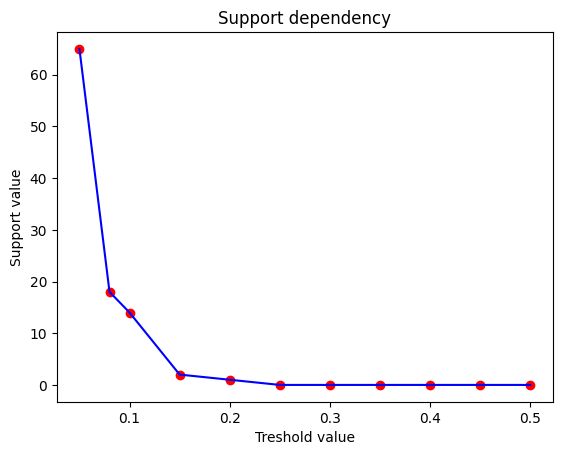

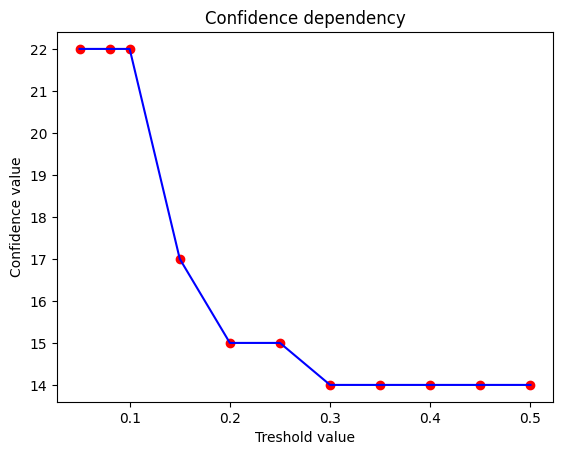

In [19]:
def build_dependency(df):
    tresholds = [0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    supports_dependency = []
    confidence_dependency = []
    
    for treshold in tresholds:
        frequent_items = fpgrowth(df, min_support=treshold, use_colnames=True)
        count_rules = len(association_rules(frequent_items, metric='confidence', min_threshold=0.5))
        supports_dependency.append(count_rules)

    for treshold in tresholds:
        frequent_items = fpgrowth(df, min_support=0.1, use_colnames=True)
        count_rules = len(association_rules(frequent_items, metric='confidence', min_threshold=treshold))
        confidence_dependency.append(count_rules)

    dependencies = {'Support': supports_dependency, 'Confidence': confidence_dependency}
    
    for k, item in dependencies.items():
        plt.scatter(tresholds, item, color='red')
        plt.plot(tresholds, item, color='blue')  
        plt.xlabel('Treshold value')
        plt.ylabel(f'{k} value')
        plt.title(f'{k} dependency')
        plt.show()
            
build_dependency(df_germany)

## Представление правил в виде графа

In [30]:
G = nx.DiGraph()

for index, rule in rules_apriori.iterrows():
    antecedent = ', '.join(rule['antecedents'])
    consequent = ', '.join(rule['consequents'])
    G.add_node(antecedent)
    G.add_node(consequent)
    G.add_edge(antecedent, consequent)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=2, iterations=50)

nx.draw(G, pos, with_labels=True, arrows=True, node_size=2000, font_size=6, connectionstyle='arc3,rad=0.1')

plt.savefig('association_rules_graph.png', format='png', bbox_inches='tight')
plt.close()

## Нахождение частых элементов и правил для другой страны собственным алгоритмом (метод apriori)

In [31]:
df_different = data_general_cleaned[data_general_cleaned['Country'] == 'France']

transactions_france = df_different.groupby('InvoiceNo')['Description'].apply(lambda x: ','.join(x)).reset_index()
data_france = tencoder.fit(transactions_france['Description'].str.split(',')).transform(transactions_france['Description'].str.split(','))
df_france = pd.DataFrame(data_france, columns=tencoder.columns_)
df_france.columns = [col if col not in [None, '', ' '] else None for col in df_france.columns]
df_france = df_france.loc[:, df_france.columns.notnull()]  

apriori_fr = apr.AprioriAssociationRules(df_france, 0.1)
apriori_fr.find_frequent_itemsets()
apriori_fr.display_frequent_itemsets()
apriori_fr.generate_association_rules(0.6)
apriori_fr.display_rules()

Frequent Itemsets:
1. {'alarm clock bakelike pink'}: 0.10
2. {'lunch bag apple design'}: 0.12
3. {'lunch bag red retrospot'}: 0.15
4. {'lunch bag spaceboy design'}: 0.12
5. {'lunch bag woodland'}: 0.12
6. {'lunch box with cutlery retrospot'}: 0.14
7. {'mini paint set vintage'}: 0.10
8. {'pack of 72 retrospot cake cases'}: 0.10
9. {'plasters in tin circus parade'}: 0.17
10. {'plasters in tin spaceboy'}: 0.14
11. {'plasters in tin woodland animals'}: 0.17
12. {'postage'}: 0.77
13. {'rabbit night light'}: 0.19
14. {'red retrospot mini cases'}: 0.14
15. {'red toadstool led night light'}: 0.18
16. {'regency cakestand 3 tier'}: 0.12
17. {'round snack boxes set of 4 fruits'}: 0.11
18. {'round snack boxes set of4 woodland'}: 0.16
19. {'set/20 red retrospot paper napkins'}: 0.13
20. {'set/6 red spotty paper cups'}: 0.14
21. {'set/6 red spotty paper plates'}: 0.13
22. {'spaceboy lunch box'}: 0.12
23. {'strawberry lunch box with cutlery'}: 0.12
24. {'lunch bag apple design', 'postage'}: 0.10
25. 

### 